In [1]:
# imports
import pathlib, pickle
from io import BytesIO
import numpy as np, matplotlib.pyplot as plt
from matplotlib.patches import FancyArrow
from PIL import Image
from sqlalchemy import create_engine, select, update
from flyerdetection.flyer_analysis_entry import FlyerAnalysisEntry
from flyerdetection.flyer_image_entry import FlyerImageEntry
from flyerdetection.metadata_link_entry import MetadataLinkEntry

In [19]:
# # read the credentials from the pickle file
# flyer_analysis_DB_auth_pickle_file_path = pathlib.Path(".")/"flyer_analysis_db_auth.pkl"
# with open(flyer_analysis_DB_auth_pickle_file_path,"rb") as fp:
#     auth = pickle.load(fp)

# connect to the database
sqlite_db_path = pathlib.Path(".").resolve().parent.parent / "TESTING.db"
db_connection_string = f"sqlite:///{sqlite_db_path.resolve()}"
#db_connection_string = (
#    f"mssql+pymssql://{auth['username']}:{auth['password']}"
#    f"@{auth['ip_address']}:{auth['port']}/{auth['db_name']}?charset=utf8"
#)
engine = create_engine(db_connection_string)  # ,echo=True)

### Visualizing correcting tilt values

In [100]:
stmt = (
    select(
        FlyerAnalysisEntry.ID,
        FlyerAnalysisEntry.metadata_link_ID,
        FlyerAnalysisEntry.rel_filepath,
        FlyerAnalysisEntry.radius,
        FlyerAnalysisEntry.tilt,
        FlyerAnalysisEntry.center_row,
        FlyerAnalysisEntry.center_column,
        FlyerImageEntry.camera_image,
        FlyerImageEntry.analysis_image,
    )
    .join(FlyerImageEntry)
    .order_by(FlyerAnalysisEntry.rel_filepath)
)
with engine.connect() as conn:
    res = conn.execute(stmt)

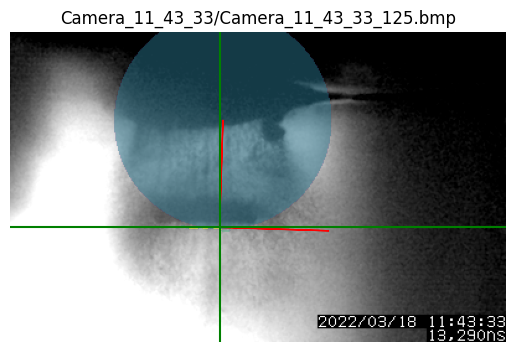

Old tilt angle = -6.2235, new tilt angle = -1.8231


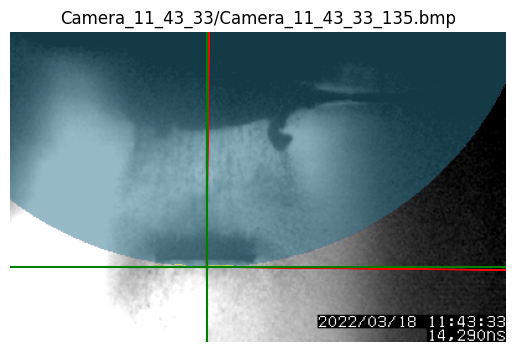

Old tilt angle = 7.0508, new tilt angle = -0.5897


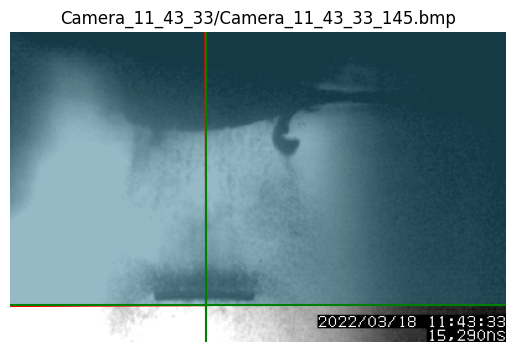

Old tilt angle = 0.1718, new tilt angle = 0.1275


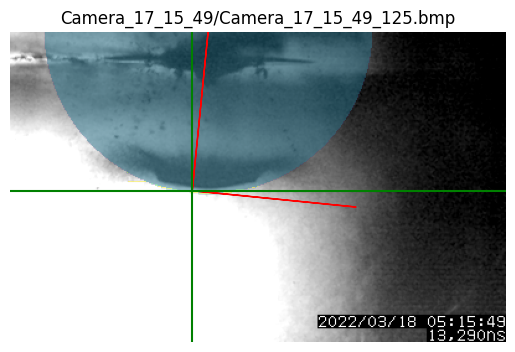

Old tilt angle = -10.7225, new tilt angle = -5.6891


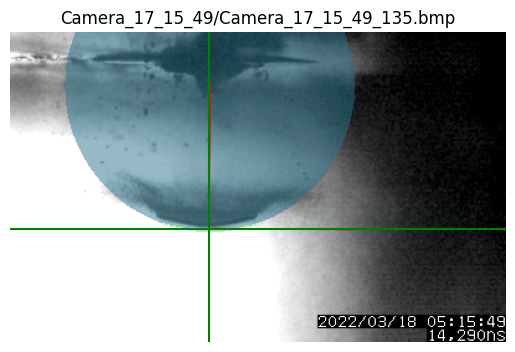

Old tilt angle = -0.3860, new tilt angle = -0.3860


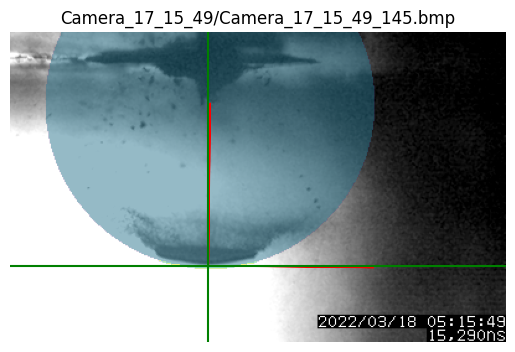

Old tilt angle = 15.5032, new tilt angle = -0.6219


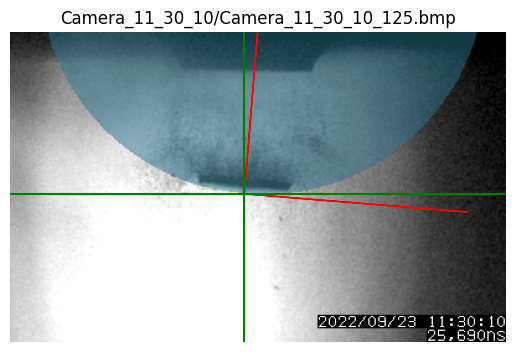

Old tilt angle = -16.8474, new tilt angle = -4.6740


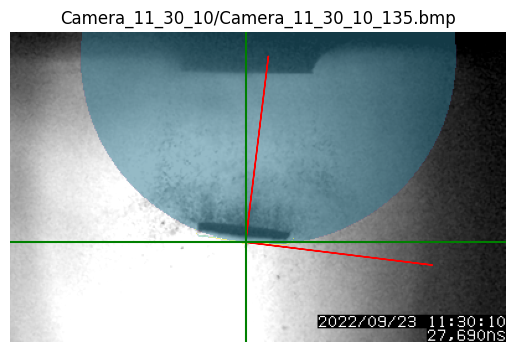

Old tilt angle = -11.5210, new tilt angle = -6.9908


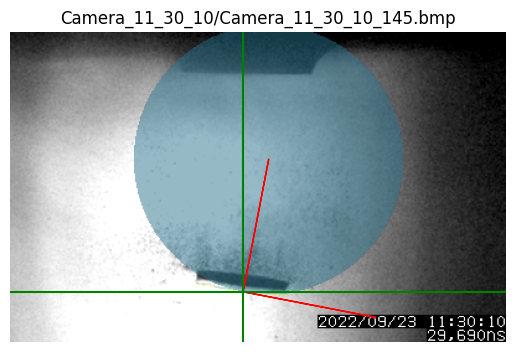

Old tilt angle = 1.0804, new tilt angle = -10.9190


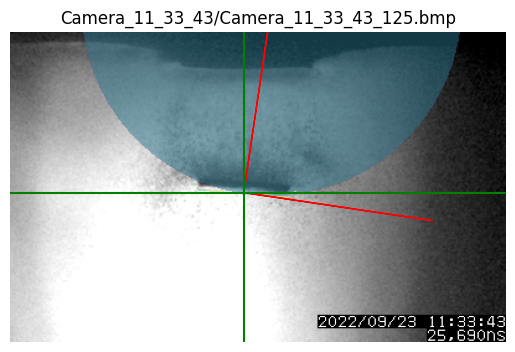

Old tilt angle = -19.3019, new tilt angle = -8.4636


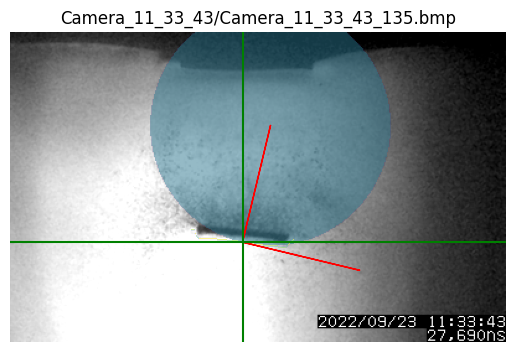

Old tilt angle = -16.2338, new tilt angle = -13.4965


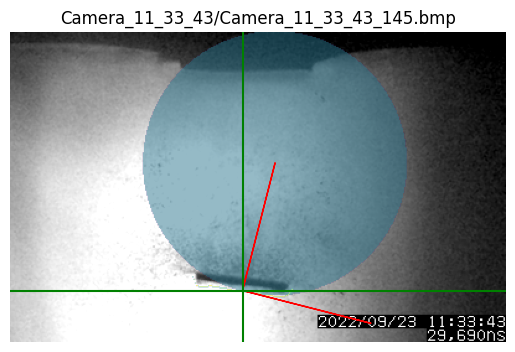

Old tilt angle = -0.7099, new tilt angle = -14.3233


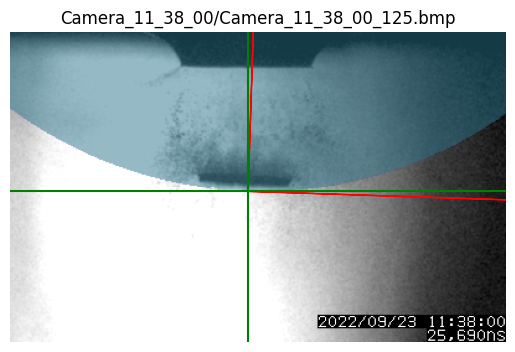

Old tilt angle = -10.5749, new tilt angle = -1.8816


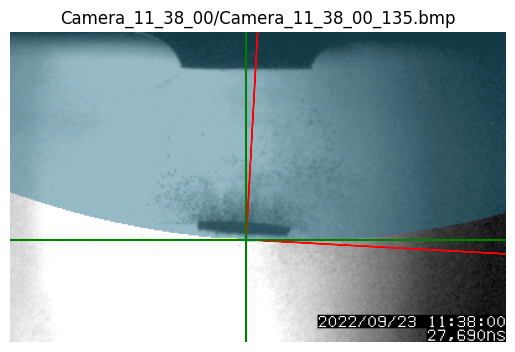

Old tilt angle = -4.8335, new tilt angle = -3.1275


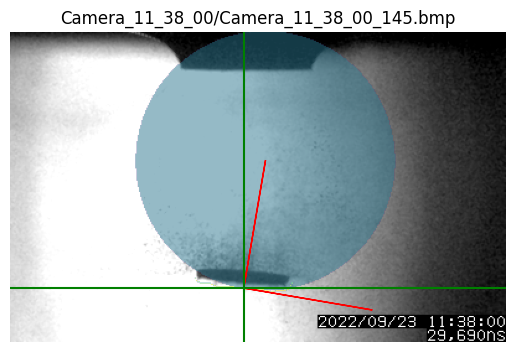

Old tilt angle = 0.8549, new tilt angle = -9.6734


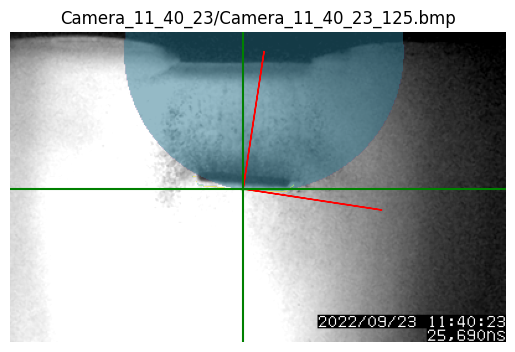

Old tilt angle = -22.0411, new tilt angle = -8.6672


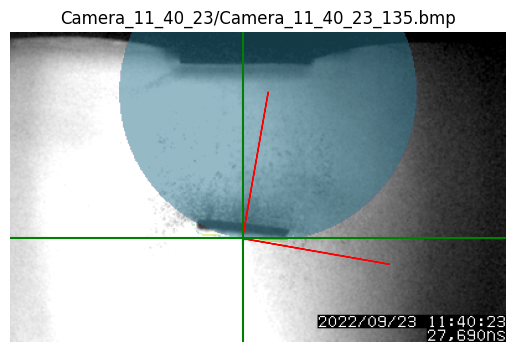

Old tilt angle = -14.2956, new tilt angle = -9.9676


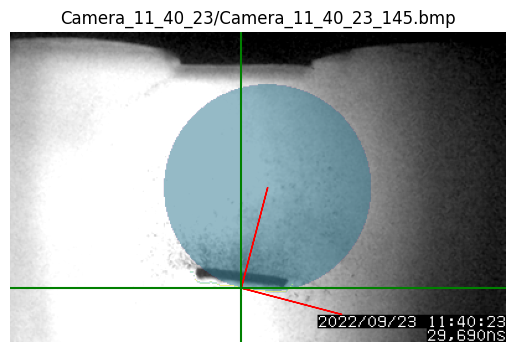

Old tilt angle = 0.5761, new tilt angle = -14.7208


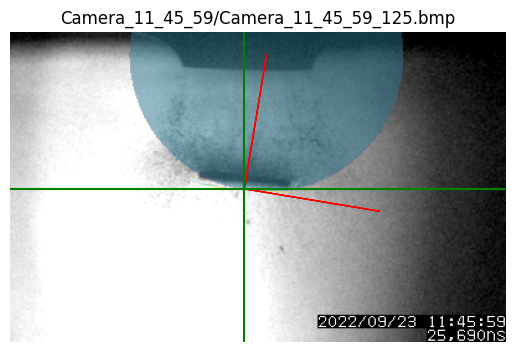

Old tilt angle = -22.6248, new tilt angle = -9.3990


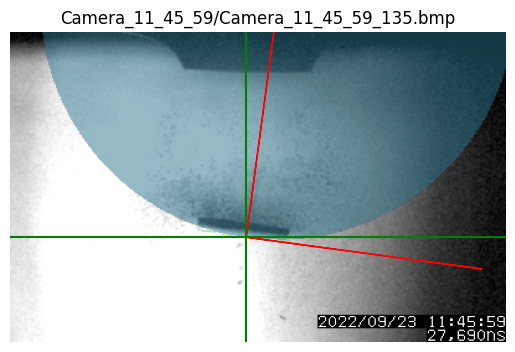

Old tilt angle = -12.0009, new tilt angle = -7.6773


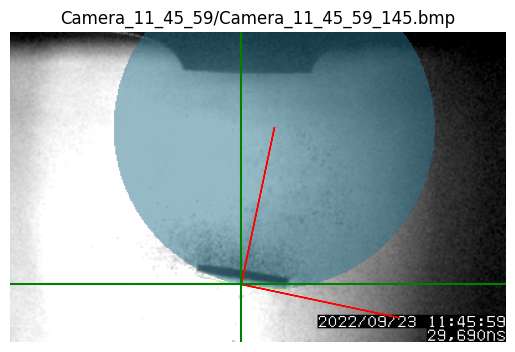

Old tilt angle = -3.0464, new tilt angle = -11.9571


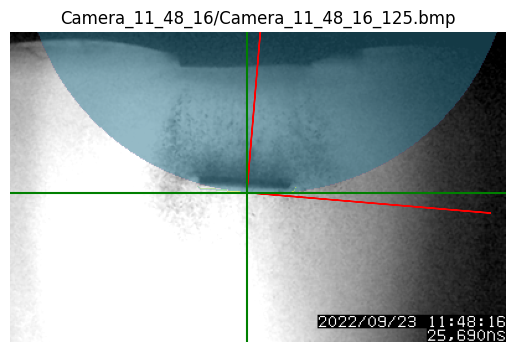

Old tilt angle = -15.9835, new tilt angle = -4.8030


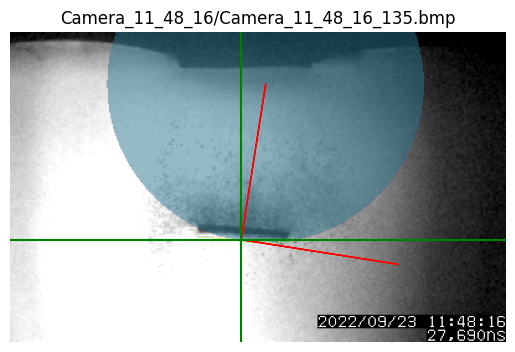

Old tilt angle = -12.8108, new tilt angle = -8.9257


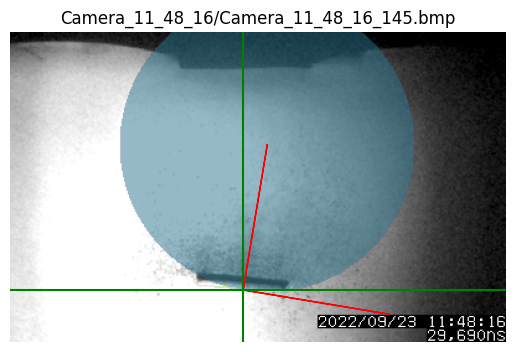

Old tilt angle = 1.0441, new tilt angle = -9.4411


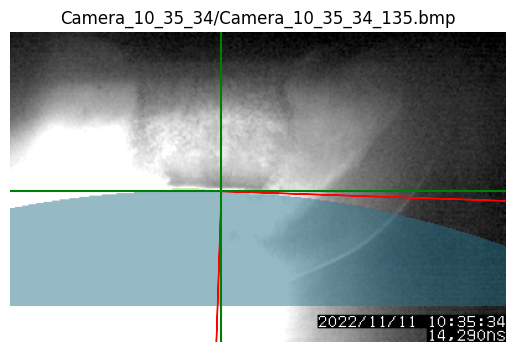

Old tilt angle = 1.4001, new tilt angle = -1.9199


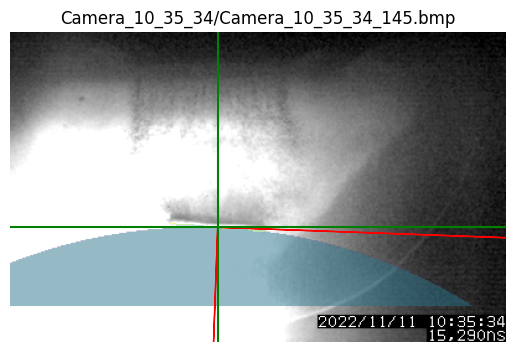

Old tilt angle = -0.8873, new tilt angle = -2.0698


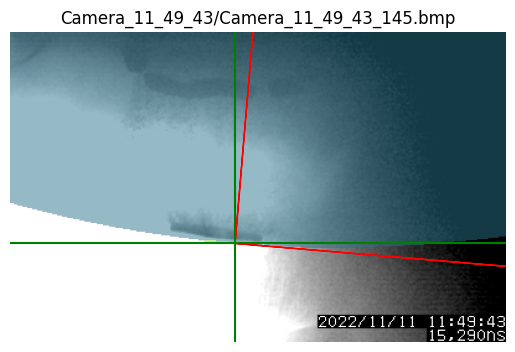

Old tilt angle = -5.4051, new tilt angle = -4.8403


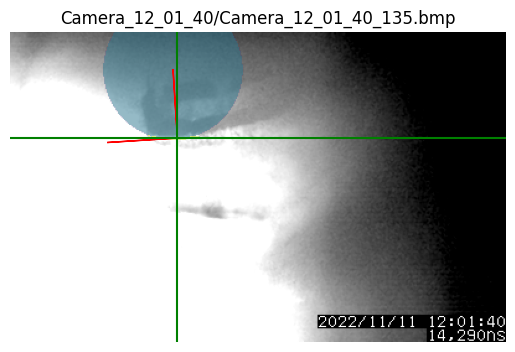

Old tilt angle = -24.0167, new tilt angle = 3.6622


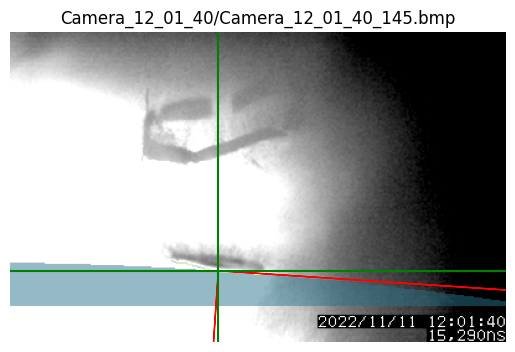

Old tilt angle = -4.3050, new tilt angle = -3.8386


In [101]:
for r in res:
    frame_number = int(r.rel_filepath.split("/")[-1].split("_")[-1][: -len(".bmp")])
    #if r.metadata_link_ID!=1 :
    #    continue
    if frame_number not in (125, 135, 145):
        continue
    if not r.analysis_image:
        continue
    analysis_image = np.load(BytesIO(r.analysis_image))["arr_0"]
    flyer_row, flyer_col = np.nonzero(np.where(analysis_image > 200, 1, 0))
    flyer_center_x = np.median(flyer_col)
    flyer_center_y = np.median(flyer_row)
    sin_tilt = (r.center_column - flyer_center_x)/r.radius
    cos_tilt = (r.center_row - flyer_center_y)/r.radius
    #new_tilt = np.arccos(cos_tilt)
    new_tilt = np.arctan(
        (r.center_column - flyer_center_x) / (r.center_row - flyer_center_y)
    )
    camera_image = np.asarray(Image.open(BytesIO(r.camera_image)))
    analysis_overlay = np.zeros_like(camera_image)
    analysis_overlay[: analysis_image.shape[0], :] = analysis_image
    arrow = FancyArrow(
        flyer_center_x,
        flyer_center_y,
        (r.center_column - flyer_center_x),
        (r.center_row - flyer_center_y),
        width=0.1,
        color="r",
    )
    right_angle_angle = new_tilt+(abs(new_tilt)/new_tilt)*np.pi/2.
    right_angle_arrow_width = -1.*r.radius*np.sin(right_angle_angle)
    right_angle_arrow_height = -1.*r.radius*np.cos(right_angle_angle)
    right_angle_arrow = FancyArrow(
        flyer_center_x,
        flyer_center_y,
        right_angle_arrow_width,
        right_angle_arrow_height,
        width=0.1,
        color="r",
    )
    f, ax = plt.subplots()
    ax.imshow(camera_image, cmap="gray")
    analysis_im_alphas = 0.5 * np.ones_like(analysis_overlay)
    analysis_im_alphas[analysis_overlay == 0] = 0
    ax.imshow(analysis_overlay, alpha=analysis_im_alphas)
    ax.add_patch(arrow)
    ax.add_patch(right_angle_arrow)
    ax.axvline(flyer_center_x, color="g")
    ax.axhline(flyer_center_y, color="g")
    ax.set_title("/".join(r.rel_filepath.split("/")[-2:]))
    ax.axis("off")
    plt.show()
    print(
        f"Old tilt angle = {180.*(r.tilt/np.pi):.4f}, new tilt angle = {180.*(new_tilt/np.pi):.4f}"
    )

### Differences in tilt as a function of error from switching flyer center x/y

In [114]:
stmt = (
    select(
        FlyerAnalysisEntry.ID,
        FlyerAnalysisEntry.tilt,
        FlyerAnalysisEntry.center_row,
        FlyerAnalysisEntry.center_column,
        FlyerImageEntry.analysis_image,
    )
    .join(FlyerImageEntry)
)
with engine.connect() as conn:
    res = conn.execute(stmt)

In [115]:
old_tilts = []
new_tilts = []
flyer_center_xs = []
flyer_center_ys = []
fit_center_xs = []
fit_center_ys = []
for r in res:
    if not r.analysis_image:
        continue
    old_tilts.append(r.tilt)
    analysis_image = np.load(BytesIO(r.analysis_image))["arr_0"]
    flyer_row, flyer_col = np.nonzero(np.where(analysis_image > 200, 1, 0))
    flyer_center_x = np.median(flyer_col)
    flyer_center_xs.append(flyer_center_x)
    flyer_center_y = np.median(flyer_row)
    flyer_center_ys.append(flyer_center_y)
    new_tilt = np.arctan(
        (r.center_column - flyer_center_x) / (r.center_row - flyer_center_y)
    )
    new_tilts.append(new_tilt)
    fit_center_xs.append(r.center_column)
    fit_center_ys.append(r.center_row)
old_tilts = np.array(old_tilts)
new_tilts = np.array(new_tilts)
flyer_center_xs = np.array(flyer_center_xs)
flyer_center_ys = np.array(flyer_center_ys)
fit_center_xs = np.array(fit_center_xs)
fit_center_ys = np.array(fit_center_ys)

In [126]:
pct_tilt_errs = 100.*(old_tilts-new_tilts)/new_tilts
pct_horiz_errs = 100.*((fit_center_xs-flyer_center_ys)-(fit_center_xs-flyer_center_xs))/(fit_center_xs-flyer_center_xs)
pct_vert_errs = 100.*((fit_center_ys-flyer_center_xs)-(fit_center_ys-flyer_center_ys))/(fit_center_ys-flyer_center_ys)

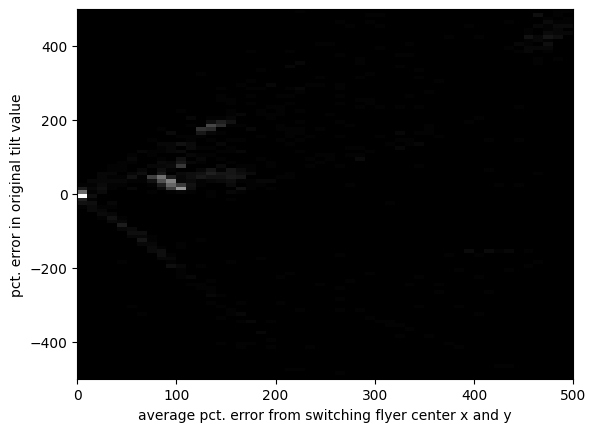

In [133]:
f,ax = plt.subplots()
ax.hist2d(0.5*(np.abs(pct_horiz_errs)+np.abs(pct_vert_errs)),pct_tilt_errs,bins=(50,100),range=((0.,500.),(-500.,500.)),cmap="gray")
ax.set_xlabel("average pct. error from switching flyer center x and y")
ax.set_ylabel("pct. error in original tilt value")
plt.show()

### Actually overwriting tilt values in the real DB

In [2]:
# read the credentials from the pickle file
flyer_analysis_DB_auth_pickle_file_path = pathlib.Path(".")/"flyer_analysis_db_auth.pkl"
with open(flyer_analysis_DB_auth_pickle_file_path,"rb") as fp:
    auth = pickle.load(fp)

# connect to the database
db_connection_string = (
    f"mssql+pymssql://{auth['username']}:{auth['password']}"
    f"@{auth['ip_address']}:{auth['port']}/{auth['db_name']}?charset=utf8"
)
engine = create_engine(db_connection_string)  # ,echo=True)

In [3]:
stmt = (
    select(
        FlyerAnalysisEntry.ID,
        FlyerAnalysisEntry.tilt,
        FlyerAnalysisEntry.center_row,
        FlyerAnalysisEntry.center_column,
        FlyerImageEntry.analysis_image,
    )
    .join(FlyerImageEntry)
)
with engine.connect() as conn:
    res = conn.execute(stmt).all()

In [4]:
for r in res:
    if not r.analysis_image:
        continue
    analysis_image = np.load(BytesIO(r.analysis_image))["arr_0"]
    flyer_row, flyer_col = np.nonzero(np.where(analysis_image > 200, 1, 0))
    flyer_center_x = np.median(flyer_col)
    flyer_center_y = np.median(flyer_row)
    new_tilt = np.arctan(
        (r.center_column - flyer_center_x) / (r.center_row - flyer_center_y)
    )
    stmt = (
        FlyerAnalysisEntry.__table__.update()
        .where(FlyerAnalysisEntry.ID==r.ID)
        .values(tilt=new_tilt)
    )
    with engine.connect() as conn:
        update_res = conn.execute(stmt)
        conn.commit()

/tmp/ipykernel_34852/1797226342.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  (r.center_column - flyer_center_x) / (r.center_row - flyer_center_y)


### Re-generating metadata links

In [7]:
import datetime
from sqlalchemy import and_
from sqlalchemy.orm import sessionmaker
from flyerdetection.metadata_link_entry import TC_FILENAME_REGEX, HS_TAG_REGEX, DATESTAMP_REGEX, CAMERA_FILENAME_REGEX
from flyerdetection.orm_base import ORMBase

def get_link_fields_from_relative_filepath(rel_filepath):
    """
    Given a relative filepath for a particular frame .bmp file, return the
    values for the fields in its corresponding MetadataLinkEntry
    """
    rdict = {
        "datestamp": None,
        "experiment_day_counter": None,
        "camera_filename": None,
    }
    # check if the filename matches the "TC--*" pattern
    if TC_FILENAME_REGEX.match(rel_filepath.name):
        date_str = rel_filepath.name.split("--")[1]
        rdict["datestamp"] = datetime.datetime.strptime(date_str, "%Y%m%d")
        rdict["experiment_day_counter"] = rel_filepath.name[: -len(".bmp")].split(
            "--"
        )[-1]
    parts = rel_filepath.parts
    # look for exactly one thing in the path like "HS--(datestamp)--(counter)"
    hs_parts = [part for part in parts if HS_TAG_REGEX.match(part)]
    if len(hs_parts) == 1:
        date_str = hs_parts[0].split("--")[1]
        rdict["datestamp"] = datetime.datetime.strptime(date_str, "%Y%m%d")
        rdict["experiment_day_counter"] = hs_parts[0].split("--")[-1]
    # next look for exactly one thing in the path like "yyyy_mm_dd"
    datestamp_parts = [part for part in parts if DATESTAMP_REGEX.match(part)]
    if len(datestamp_parts) == 1:
        rdict["datestamp"] = datetime.datetime.strptime(
            datestamp_parts[0], "%Y_%m_%d"
        )
    # finally, look for exactly one thing in the path like "Camera_hh_mm_ss"
    camera_filename_parts = [
        part for part in parts if CAMERA_FILENAME_REGEX.match(part)
    ]
    if len(camera_filename_parts) == 1:
        rdict["camera_filename"] = "_".join(camera_filename_parts[0].split("_")[1:])
    # return whatever we've found
    return rdict

def get_metadata_link_ID_for_filepath(rel_filepath, engine, session):
    """
    Return the ID of a metadata link entry created for the video containing the given
    frame result. Creates the record if necessary.
    """
    # Determine the fields for the entry from the relative filepath
    fields = get_link_fields_from_relative_filepath(rel_filepath)
    # Figure out the conditions for the query
    conditions = []
    if fields["datestamp"]:
        conditions.append(MetadataLinkEntry.datestamp == fields["datestamp"])
    if fields["experiment_day_counter"]:
        conditions.append(
            MetadataLinkEntry.experiment_day_counter
            == fields["experiment_day_counter"]
        )
    if fields["camera_filename"]:
        conditions.append(
            MetadataLinkEntry.camera_filename == fields["camera_filename"]
        )
    # At least one field must be determined
    if len(conditions) < 1:
        return None
    stmt = select(MetadataLinkEntry.ID).where(and_(*conditions))
    # If a matching entry already exists, return its ID
    with engine.connect() as conn:
        result = conn.execute(stmt).first()
    if result:
        return result[0]
    # If not, create and commit the entry and return its ID
    new_entry = MetadataLinkEntry(**fields)
    session.add(new_entry)
    session.commit()
    return new_entry.ID

In [8]:
# read the credentials from the pickle file
flyer_analysis_DB_auth_pickle_file_path = pathlib.Path(".")/"flyer_analysis_db_auth.pkl"
with open(flyer_analysis_DB_auth_pickle_file_path,"rb") as fp:
    auth = pickle.load(fp)

# connect to the database
db_connection_string = (
    f"mssql+pymssql://{auth['username']}:{auth['password']}"
    f"@{auth['ip_address']}:{auth['port']}/{auth['db_name']}?charset=utf8"
)
engine = create_engine(db_connection_string)  # ,echo=True)
session = sessionmaker(bind=engine)()

In [11]:
stmt = (
    select(
        FlyerAnalysisEntry.ID,
        FlyerAnalysisEntry.rel_filepath,
        FlyerAnalysisEntry.metadata_link_ID,
    )
)
with engine.connect() as conn:
    res = conn.execute(stmt).all()

In [12]:
for r in res:
    metadata_link_id = get_metadata_link_ID_for_filepath(pathlib.Path(r.rel_filepath),engine,session)
    if metadata_link_id==r.metadata_link_ID:
        continue
    stmt = (
        FlyerAnalysisEntry.__table__.update()
        .where(FlyerAnalysisEntry.ID==r.ID)
        .values(metadata_link_ID=metadata_link_id)
    )
    with engine.connect() as conn:
        update_res = conn.execute(stmt)
        conn.commit()

In [15]:
from sqlalchemy import delete

with engine.connect() as conn:
    metadata_link_ids = [res.ID for res in conn.execute(select(MetadataLinkEntry.ID)).all()]
for metadata_link_id in metadata_link_ids:
    stmt = (
        select(FlyerAnalysisEntry.exit_code)
        .where(FlyerAnalysisEntry.metadata_link_ID==metadata_link_id)
    )
    with engine.connect() as conn:
        video_exit_codes = [res.exit_code for res in conn.execute(stmt).all()]
    n_total_frames = len(video_exit_codes)
    if n_total_frames==0:
        with engine.connect() as conn:
            metadata_link_entry = conn.execute(select(MetadataLinkEntry).where(MetadataLinkEntry.ID==metadata_link_id)).all()
        print(f"will delete unreferenced metadata link entry {metadata_link_entry}")
        with engine.connect() as conn:
            delete_res = conn.execute(MetadataLinkEntry.__table__.delete().where(MetadataLinkEntry.ID==metadata_link_id))
            conn.commit()

will delete unreferenced metadata link entry [(146, datetime.datetime(2022, 6, 16, 0, 0), '00003', None)]
will delete unreferenced metadata link entry [(169, datetime.datetime(2022, 6, 20, 0, 0), '00020', None)]
will delete unreferenced metadata link entry [(216, datetime.datetime(2022, 6, 23, 0, 0), '00021', None)]
will delete unreferenced metadata link entry [(218, datetime.datetime(2022, 6, 23, 0, 0), '00024', None)]
will delete unreferenced metadata link entry [(243, datetime.datetime(2022, 6, 24, 0, 0), '00024', None)]
will delete unreferenced metadata link entry [(302, datetime.datetime(2022, 6, 28, 0, 0), '00021', None)]
will delete unreferenced metadata link entry [(351, datetime.datetime(2022, 6, 30, 0, 0), '00005', None)]
will delete unreferenced metadata link entry [(404, datetime.datetime(2022, 7, 5, 0, 0), '00031', None)]
will delete unreferenced metadata link entry [(457, datetime.datetime(2022, 7, 27, 0, 0), '00003', None)]
will delete unreferenced metadata link entry [(